/Users/e0919678/tensorflow/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch 0, Loss: 0.26443013548851013
Epoch 100, Loss: 0.02696549892425537
Epoch 200, Loss: 0.02714325115084648
Epoch 300, Loss: 0.02728118747472763
Epoch 400, Loss: 0.02715102955698967
Epoch 500, Loss: 0.025195807218551636
Epoch 600, Loss: 0.02561020292341709
Epoch 700, Loss: 0.02504054643213749
Epoch 800, Loss: 0.025599822402000427
Epoch 900, Loss: 0.024166952818632126
Epoch 1000, Loss: 0.024883918464183807
Epoch 1100, Loss: 0.024150831624865532
Epoch 1200, Loss: 0.024630289524793625
Epoch 1300, Loss: 0.024380333721637726
Epoch 1400, Loss: 0.02358400635421276
Epoch 1500, Loss: 0.02390889637172222
Epoch 1600, Loss: 0.02413342520594597
Epoch 1700, Loss: 0.02231016382575035
Epoch 1800, Loss: 0.022265253588557243
Epoch 1900, Loss: 0.021929068490862846
2048/2048 [==============================] - 1s 309us/step


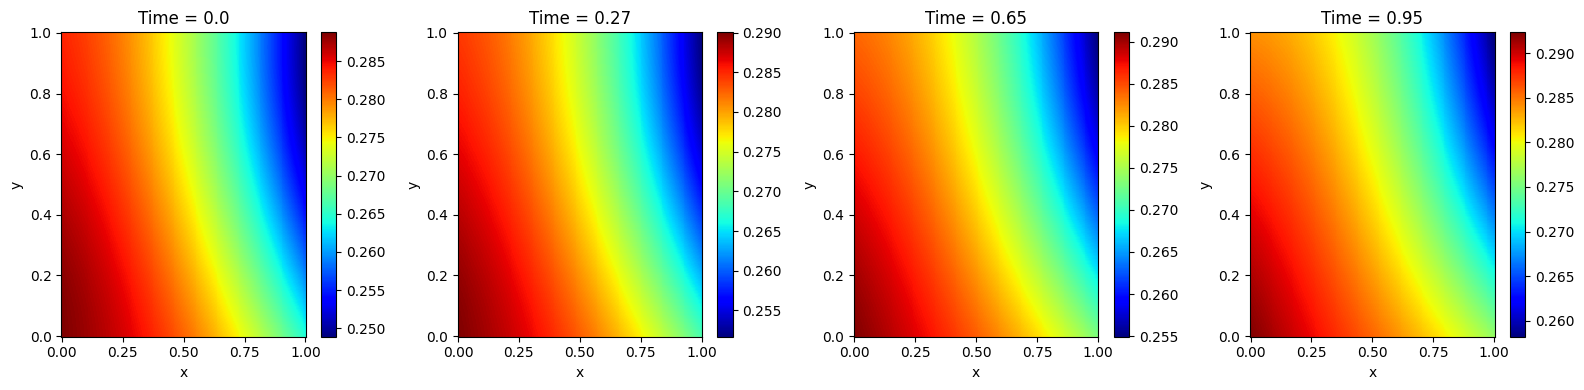

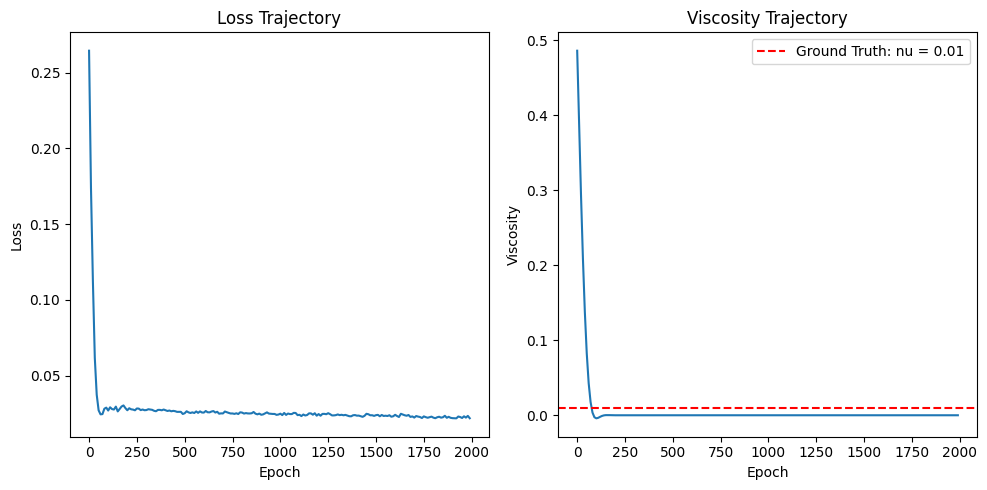

nu_max:  <tf.Variable 'artificial_viscosity:0' shape=() dtype=float32, numpy=-1.3121582e-10>


In [1]:
# v16 12 Oct 2023 
# artificial viscosity - achieved with TF variables
# made adjustment on IC/BC loss functions

## parametric method: 1D - done
# ###### the shock width decreases with time ###### and loss and nu_max trajectory shows reasonable.
# However the theta_map and nu_map show random values all over the place without the "Gaussian distribution" 
    # - designating the map instead of leaving it random
# Designate the Gaussian distribution over the viscosity map
# Include t_shock and std_dev as part of the learnable variables


import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import griddata

# data = scipy.io.loadmat('burgers_shock.mat')
# Exact = data['usol']
# Exact_u = np.real(Exact)

# Define the domain class
class Domain:
    def __init__(self, x_min, x_max, y_min, y_max, t_min, t_max, num_x, num_y, num_t, viscosity_init_v, batch_size):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.t_min = t_min
        self.t_max = t_max
        self.num_x = num_x
        self.num_y = num_y
        self.num_t = num_t
        self.batch_size_r = batch_size[0]
        self.batch_size_0 = batch_size[1]
        self.batch_size_b = batch_size[2]
        self.viscosity = tf.Variable(initial_value=tf.ones([]) * viscosity_init_v, 
                                     trainable=True, 
                                     dtype=tf.float32,
                                     name="artificial_viscosity")
        # self.theta = tf.Variable(initial_value=tf.ones([batch_size[0], 1]) * 0.5, 
        #                              trainable=True, 
        #                              dtype=tf.float32,
        #                              name="viscosity_map_coefficient")
        # self.t_shock = tf.Variable(initial_value=0.5, 
        #                            trainable=True,
        #                            dtype=tf.float32,
        #                            name="shock_happen_time")
        # self.std_dev = tf.Variable(initial_value=0.3,
        #                            trainable=True,
        #                            dtype=tf.float32,
        #                            name="standard_deviation_for_GD")
    
# Define the initial condition
def initial_condition(domain, x, y):
    # initial_output = np.where(x > 0, 1, 0)
    u = np.sin(np.pi * x) * np.cos(np.pi * y)
    v = np.cos(np.pi * x) * np.sin(np.pi * y)
    IC_output = np.sqrt(u ** 2 + v ** 2) # output the magnitude of whole velocity
    return IC_output 

# Define the boundary conditions
def boundary_conditions(domain, x, y, t):
    return np.zeros_like(x)

# def viscosity_mapping(x, t, epoch):
#     nu_map = np.where(t >= domain.t_shock, np.exp(-((x - 0) ** 2) / (2 * domain.std_dev ** 2)), 0) # * domain.theta  # gaussian_distribution
#     viscosity = domain.viscosity * nu_map # tf.sigmoid(nu_map)
#     storage = [x, t, domain.theta, viscosity, epoch] # parameter_s components: 0x, 1t, 2theta, 3nu, 4epoch
#     return storage 

# Define the physics-informed loss function
def physics_informed_loss(network, domain, x, y, t, epoch):
    
    # define a viscosity map, displaying the preference of AV on domain
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(y)
        tape.watch(t)

        # t_shock_broadcasted = tf.fill(x.shape, domain.t_shock) # make shape compatible for the network inputs [epoch_number,1]
        # std_dev_broadcasted = tf.fill(x.shape, domain.std_dev) # make shape compatible for the network inputs [epoch_number,1]
        r_output = network(tf.concat([x, y, t], axis=1))

        u = r_output[0]
        v = r_output[1]
        u_x = tape.gradient(u, x) # cancel: Reshape x to [32,1]
        u_y = tape.gradient(u, y)
        u_t = tape.gradient(u, t) # solved: u_t showed NoneType
        u_xx = tape.gradient(u_x, x)
        u_yy = tape.gradient(u_y, y)

        v_x = tape.gradient(v, x) # cancel: Reshape x to [32,1]
        v_y = tape.gradient(v, y)
        v_t = tape.gradient(v, t) # solved: u_t showed NoneType
        v_xx = tape.gradient(v_x, x)
        v_yy = tape.gradient(v_y, y)

        # Debugging: Check if any tensors contain NaN values
        tf.debugging.assert_all_finite(u_x, "u_x contains NaN values")
        tf.debugging.assert_all_finite(u_y, "u_x contains NaN values")
        tf.debugging.assert_all_finite(u_t, "u_t contains NaN values")

        tf.debugging.assert_all_finite(v_x, "v_x contains NaN values")
        tf.debugging.assert_all_finite(v_y, "u_x contains NaN values")
        tf.debugging.assert_all_finite(v_t, "v_t contains NaN values")
        
        # define the parametric viscosity map with the collocation points in the residual learning batch
        # keep record of the parameters: x_coords, t_coords, theta, product of nu_max and nu_map
        
        # parameter_storage = viscosity_mapping(x, t, epoch)

        # Define the Burgers equation residual
        r1 = u_t + u * u_x + v * u_y - domain.viscosity * (u_xx + u_yy) # viscosity: []
        r2 = v_t + u * v_x + v * v_y - domain.viscosity * (v_xx + v_yy) # viscosity: []
        # r3 = u_y + u_x 
        residual = r1 + r2 # + r3
        # viscosity_map: nu_max * nu_map
    # tf.fill(x_batch_0.shape, domain.t_shock), 
    # tf.fill(x_batch_0.shape, domain.std_dev)
    # Compute the loss for initial condition
    t_batch_0 = tf.fill([domain.batch_size_0, 1], 0.0001) # considered as 0
    x_batch_0 = tf.random.uniform([domain.batch_size_0, 1], minval=domain.x_min, maxval=domain.x_max)
    y_batch_0 = tf.random.uniform([domain.batch_size_0, 1], minval=domain.y_min, maxval=domain.y_max)
    output_0 = network(tf.concat([x_batch_0, y_batch_0, t_batch_0], axis=1))
    initial_residual = np.sqrt(output_0[0] ** 2 + output_0[1] ** 2) - initial_condition(domain, x_batch_0, y_batch_0)
    
    # with tf.GradientTape(persistent=True) as tape:
    # initial_residual_vorticity = 

    # Compute the loss for boundary condition
    x_batch_bl = tf.cast(tf.fill([domain.batch_size_b, 1], 0), dtype=tf.float32) # left
    x_batch_br = tf.cast(tf.fill([domain.batch_size_b, 1], 1), dtype=tf.float32) # right
    y_batch_bd = tf.cast(tf.fill([domain.batch_size_b, 1], 0), dtype=tf.float32) # down
    y_batch_bu = tf.cast(tf.fill([domain.batch_size_b, 1], 1), dtype=tf.float32) # up
    t_batch_b  = tf.random.uniform([domain.batch_size_b, 1], minval=domain.t_min, maxval=domain.t_max)
    output_b_ld = network(tf.concat([x_batch_bl, y_batch_bd, t_batch_b], axis=1))  # tf.fill(x_batch_bl.shape, domain.std_dev) 
    output_b_lu = network(tf.concat([x_batch_bl, y_batch_bu, t_batch_b], axis=1)) 
    output_b_rd = network(tf.concat([x_batch_br, y_batch_bd, t_batch_b], axis=1)) 
    output_b_ru = network(tf.concat([x_batch_br, y_batch_bu, t_batch_b], axis=1)) 
    boundary_residual_ld = np.sqrt(output_b_ld[0] ** 2 + output_b_ld[1] ** 2) - boundary_conditions(domain, x_batch_bl, y_batch_bd, t_batch_b)
    boundary_residual_lu = np.sqrt(output_b_lu[0] ** 2 + output_b_lu[1] ** 2) - boundary_conditions(domain, x_batch_bl, y_batch_bu, t_batch_b)
    boundary_residual_rd = np.sqrt(output_b_rd[0] ** 2 + output_b_rd[0] ** 2) - boundary_conditions(domain, x_batch_br, y_batch_bd, t_batch_b)
    boundary_residual_ru = np.sqrt(output_b_ru[0] ** 2 + output_b_ru[1] ** 2) - boundary_conditions(domain, x_batch_br, y_batch_bu, t_batch_b)

    boundary_residual = boundary_residual_ld + boundary_residual_lu + boundary_residual_rd + boundary_residual_ru
    

    viscosity_loss = tf.square(tf.reduce_max(domain.viscosity)) # square the maximum element
    loss = tf.reduce_mean(tf.square(residual)) / domain.batch_size_r + \
           tf.reduce_mean(tf.square(initial_residual)) / domain.batch_size_0 + \
           tf.reduce_mean(tf.square(boundary_residual)) / domain.batch_size_b + \
            viscosity_loss
    
    return loss #, parameter_storage

# Define the neural network model
def create_network():
    network = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(3,)), # x, t, t_shock, std_dev for the GD
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(2)
    ])
    return network

# Train the model using PINNs
def train_model(network, domain, num_epochs, learning_rate):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # List to store loss and viscosity values for each epoch
    history = [[] for _ in range(4)]  # Initialize history as a list with three empty lists
    # history components, [0]: loss, [1]: nu, [2]: t_shock

    for epoch in range(num_epochs):
        x_batch = tf.random.uniform([domain.batch_size_r, 1], minval=domain.x_min, maxval=domain.x_max)
        y_batch = tf.random.uniform([domain.batch_size_r, 1], minval=domain.y_min, maxval=domain.y_max)
        t_batch = tf.random.uniform([domain.batch_size_r, 1], minval=domain.t_min, maxval=domain.t_max)

        with tf.GradientTape() as tape:
            loss = physics_informed_loss(network, domain, x_batch, y_batch, t_batch, epoch)

        # add viscosity into the trainable variables from TF
        variable_list = network.trainable_variables + [domain.viscosity] #+ \
                        # [domain.t_shock] + [domain.std_dev] # [domain.theta] # theta no longer in use, instead considered as theta(t_shock, std_dev)

        gradients = tape.gradient(loss, variable_list)
        optimizer.apply_gradients(zip(gradients, variable_list))

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")

        if epoch % 10 == 0:
            # Append the loss and viscosity values to the history lists
            history[0].append(loss.numpy())
            history[1].append(tf.reduce_max(domain.viscosity).numpy())
            # history[2].append(domain.t_shock)
            # history[3].append(domain.std_dev)
    

    return network, history # , parameter_s

# Visualize the results
def visualize_results(model, domain, history, num_epochs):
    # Modify this part to create a grid for (x, y) coordinates
    x_grid, y_grid = np.meshgrid(np.linspace(domain.x_min, domain.x_max, domain.num_x),
                             np.linspace(domain.y_min, domain.y_max, domain.num_y))

    # Create a list of time points you want to visualize
    selected_time_points = [0.0, 0.27, 0.65, 0.95]

    # Create subplots to display multiple plots (one for each time point)
    fig, axs = plt.subplots(1, len(selected_time_points), figsize=(16, 4))

    for i, t in enumerate(selected_time_points):
        # Create a grid for time
        t_grid = np.full_like(x_grid, t)
        
        # Prepare the input data (x, y, t) for the model
        X = np.column_stack((x_grid.flatten(), y_grid.flatten(), t_grid.flatten()))
        
        # Make predictions using the model
        u_pred = model.predict(X)
        # Reshape the predicted values to match the grid shape
        u_pred_grid = u_pred[:, 0].reshape(x_grid.shape)
        v_pred_grid = u_pred[:, 1].reshape(y_grid.shape)  
        
        velo_pred_grid = np.sqrt(u_pred_grid ** 2 + v_pred_grid ** 2)
        # Create a subplot for the current time point
        ax = axs[i]
        c = ax.pcolor(x_grid, y_grid, velo_pred_grid, cmap='jet')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f'Time = {t}')
        fig.colorbar(c, ax=ax)

    plt.tight_layout()
    plt.show()

    ################ plotting traj ################
    # Define the x-axis labels at intervals of every 10 epochs
    x_labels = list(range(0, num_epochs, 10))
    # Plot the loss and viscosity trajectories
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x_labels, history[0])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Trajectory')

    plt.subplot(1, 2, 2)
    plt.plot(x_labels, history[1])
    plt.axhline(y=0.01, color='r', linestyle='--', label='Ground Truth: nu = 0.01')
    plt.xlabel('Epoch')
    plt.ylabel('Viscosity')
    plt.title('Viscosity Trajectory')
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Define domain parameters and create the domain
    x_min = 0
    x_max = 1.0
    y_min = 0
    y_max = 1.0
    t_min = 0
    t_max = 1.00
    num_x = 256
    num_y = 256
    num_t = 100
    batch_size_r=512
    num_batch_size_0 = 64
    num_batch_size_b = 64
    batch_size = [batch_size_r, num_batch_size_0, num_batch_size_b] # define batch_size list
    viscosity_init_v = tf.random.uniform(shape=(), minval=0.001, maxval=1.0)
    domain = Domain(x_min, x_max, y_min, y_max, t_min, t_max, num_x, num_y, num_t, viscosity_init_v, batch_size)
    num_epochs = 2000
    # batch_size = 1000
    # num_batch_size_0 = 128
    # num_batch_size_b = 128

    # Create the neural network 
    network = create_network()

    # Train the model using PINNs
    model, history = train_model(network,
                                 domain, 
                                 num_epochs, 
                                 learning_rate=0.01)
    
    # Visualize the results
    u_pred_grid = visualize_results(model, 
                                    domain, 
                                    history, 
                                    num_epochs
                                    )

    #TODO compare the u_pred_grid with the analytical solution

    print("nu_max: ", domain.viscosity)
    # print("t_shock:", domain.t_shock)
    # print("std_dev:", domain.std_dev)
    




2048/2048 [==============================] - 1s 251us/step


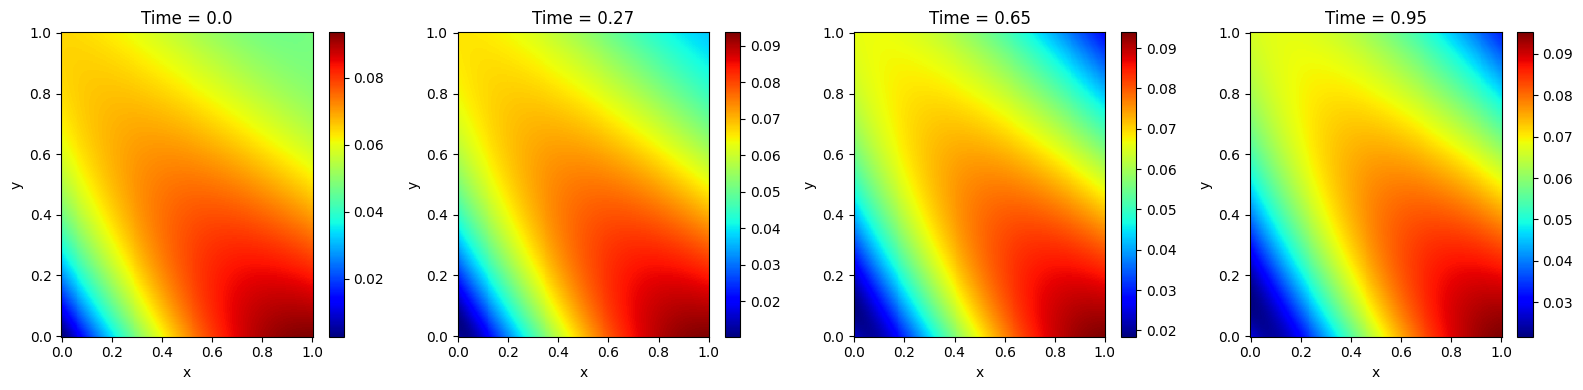

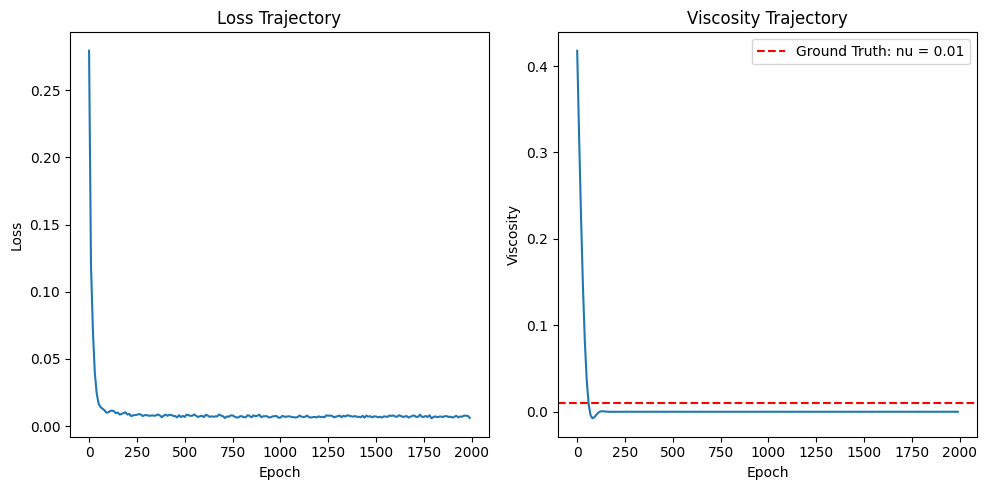

In [13]:


# Visualize the results
def visualize_results(model, domain, history, num_epochs):
    # Modify this part to create a grid for (x, y) coordinates
    x_grid, y_grid = np.meshgrid(np.linspace(domain.x_min, domain.x_max, domain.num_x),
                             np.linspace(domain.y_min, domain.y_max, domain.num_y))

    # Create a list of time points you want to visualize
    selected_time_points = [0.0, 0.27, 0.65, 0.95]

    # Create subplots to display multiple plots (one for each time point)
    fig, axs = plt.subplots(1, len(selected_time_points), figsize=(16, 4))

    for i, t in enumerate(selected_time_points):
        # Create a grid for time
        t_grid = np.full_like(x_grid, t)
        
        # Prepare the input data (x, y, t) for the model
        X = np.column_stack((x_grid.flatten(), y_grid.flatten(), t_grid.flatten()))
        
        # Make predictions using the model
        u_pred = model.predict(X)
        # Reshape the predicted values to match the grid shape
        u_pred_grid = u_pred[:, 0].reshape(x_grid.shape)
        v_pred_grid = u_pred[:, 1].reshape(y_grid.shape)  
        
        velo_pred_grid = np.sqrt(u_pred_grid ** 2 + v_pred_grid ** 2)
        # Create a subplot for the current time point
        ax = axs[i]
        c = ax.pcolor(x_grid, y_grid, velo_pred_grid, cmap='jet')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f'Time = {t}')
        fig.colorbar(c, ax=ax)

    plt.tight_layout()
    plt.show()


    # Define the x-axis labels at intervals of every 10 epochs
    x_labels = list(range(0, num_epochs, 10))

    # Plot the loss and viscosity trajectories
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x_labels, history[0])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Trajectory')

    plt.subplot(1, 2, 2)
    plt.plot(x_labels, history[1])
    plt.axhline(y=0.01, color='r', linestyle='--', label='Ground Truth: nu = 0.01')
    plt.xlabel('Epoch')
    plt.ylabel('Viscosity')
    plt.title('Viscosity Trajectory')

    # # plot the viscosity map
    # # parameter_s components: 0x, 1t, 2theta, 3nu, 4epoch
    # # Assuming 'parameter_s' is a list of three NumPy arrays with shape (256, 1)
    # # Assuming 'parameter_s' is a list of four NumPy arrays or lists
    # x_coords = np.array(parameter_s[0])  # Convert to NumPy array
    # y_coords = np.array(parameter_s[1])  # Convert to NumPy array
    # theta = np.array(parameter_s[2])     # Convert to NumPy array
    # nu = np.array(parameter_s[3])         # Convert to NumPy array
    # epoch = np.array(parameter_s[4])
    # print("epoch:", epoch)

    # plt.figure(figsize=(5, 5))
    # scatter2 = plt.scatter(x_coords, y_coords, c=nu, cmap='viridis', s=50)  # Adjust 's' for point size
    # plt.colorbar(scatter2)
    # plt.xlabel('X Coordinate')
    # plt.ylabel('T Coordinate')
    # plt.title('Scatter Plot for Viscosity Map Values')

    # # Create a histogram of nu
    # plt.figure(figsize=(5, 5))
    # plt.hist(nu, bins=30)  # You can adjust the number of bins as needed
    # plt.title('"nu_max * nu_map (actual viscosity applied to eqt.)" Distribution')
    # plt.xlabel('Viscosity Value')
    # plt.ylabel('Count')
    # plt.grid(axis='y')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

u_pred_grid = visualize_results(model, 
                                domain, 
                                history, 
                                num_epochs
                                )


In [ ]:
def visualize_results(model, domain, history, num_epochs):
    x_grid, t_grid = np.meshgrid(np.linspace(domain.x_min, domain.x_max, domain.num_x),
                                 np.linspace(domain.t_min, domain.t_max, domain.num_t))
    t_shock_grid = np.full_like(x_grid, domain.t_shock)
    std_dev_grid = np.full_like(x_grid, domain.std_dev)
    X = np.hstack((x_grid.flatten()[:, tf.newaxis], 
                   t_grid.flatten()[:, tf.newaxis], 
                   t_shock_grid.flatten()[:, tf.newaxis],
                   std_dev_grid.flatten()[:, tf.newaxis]))
    #print(X.shape)
    u_pred_grid = model.predict(X)
    # print(u_pred_grid.shape)
    u_pred_grid = griddata(X[:, 0:2], u_pred_grid.flatten(), (x_grid, t_grid), method='cubic')

    print("u_pred_shape:", u_pred_grid.shape)

    plt.figure(figsize=(8, 6))
    plt.pcolor(x_grid, t_grid, u_pred_grid, cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Predicted Velocity')
    plt.show()

    # Define the x-axis labels at intervals of every 10 epochs
    x_labels = list(range(0, num_epochs, 10))

    # Plot the loss and viscosity trajectories
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x_labels, history[0])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Trajectory')

    plt.subplot(1, 2, 2)
    plt.plot(x_labels, history[1])
    plt.axhline(y=0.01, color='r', linestyle='--', label='Ground Truth: nu = 0.01')
    plt.xlabel('Epoch')
    plt.ylabel('Viscosity')
    plt.title('Viscosity Trajectory')

    # plot the viscosity map
    # parameter_s components: 0x, 1t, 2theta, 3nu, 4epoch
    # Assuming 'parameter_s' is a list of three NumPy arrays with shape (256, 1)
    # Assuming 'parameter_s' is a list of four NumPy arrays or lists
    x_coords = np.array(parameter_s[0])  # Convert to NumPy array
    y_coords = np.array(parameter_s[1])  # Convert to NumPy array
    theta = np.array(parameter_s[2])     # Convert to NumPy array
    nu = np.array(parameter_s[3])         # Convert to NumPy array
    epoch = np.array(parameter_s[4])
    print("epoch:", epoch)

    # Create the scatter plot

    # plt.figure(figsize=(5, 5))
    # scatter1 = plt.scatter(x_coords, y_coords, c=theta, cmap='viridis', s=50)  # Adjust 's' for point size
    # plt.colorbar(scatter1)
    # plt.xlabel('X Coordinate')
    # plt.ylabel('T Coordinate')
    # plt.title('Scatter Plot for Theta Values')

    plt.figure(figsize=(5, 5))
    scatter2 = plt.scatter(x_coords, y_coords, c=nu, cmap='viridis', s=50)  # Adjust 's' for point size
    plt.colorbar(scatter2)
    plt.xlabel('X Coordinate')
    plt.ylabel('T Coordinate')
    plt.title('Scatter Plot for Viscosity Map Values')

    # Create a histogram of nu
    plt.figure(figsize=(5, 5))
    plt.hist(nu, bins=30)  # You can adjust the number of bins as needed
    plt.title('"nu_max * nu_map (actual viscosity applied to eqt.)" Distribution')
    plt.xlabel('Viscosity Value')
    plt.ylabel('Count')
    plt.grid(axis='y')
    
    plt.legend()
    plt.tight_layout()
    plt.show()
